# Lib


In [1]:
import math
import unittest

import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import matplotlib.cm as cm


class Trail:
    def __init__(self, f, cap, precision):
        self.f = f
        self.cap = lambda x: cap(x, precision)
        self.fcap = lambda x: cap(f(x), precision)
        self.precision = precision
        self.steps = []

    def record(self, a, b, x):
        self.steps.append([a, b, x, self.fcap(a), self.fcap(b), self.fcap(x)])

    def __getitem__(self, index):
        return self.steps[index]

    def __iter__(self):
        for step in self.steps:
            yield step

    def __len__(self):
        return len(self.steps)

    def __str__(self):
        return tabulate(
            self.steps,
            headers=["n", "a", "b", "x", "f(a)", "f(b)", "f(x)"],
            floatfmt=f".{self.precision}f",
            showindex=True,
        )

    @property
    def result(self):
        return self[-1][2]

    def plot(self):
        plt.subplots()

        a, b = self[0][0], self[0][1]
        x = np.arange(a - 1, b + 1, 0.01)

        plt.plot(x, self.f(x), label="f(x)")

        colors = cm.viridis(np.linspace(0, 1, len(self)))

        for i, step, color in zip(range(1, len(self)), self, colors):
            x1, x2 = step[0], step[1]
            y1, y2 = self.f(x1), self.f(x2)

            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - slope * x1

            plt.plot(x, x * slope + intercept, label=i, color=color)
            plt.scatter([x1, x2], [y1, y2], color=color)

        plt.grid(True)
        plt.legend()


def trunc(x, digits):
    n = 10**digits
    return int(x * n) / float(n)


def find_root(f, a, b, update, tolerance=None, max_iterations=None, truncate=True, precision=4):
    cap = trunc if truncate == True else round
    trail = Trail(f, cap, precision)

    i = 1
    while True:
        if f(a) * f(b) >= 0:
            raise Exception(f"f doesn't have a root between {a} and {b}")

        x = cap(update(a, b), precision)

        trail.record(a, b, x)

        if tolerance is not None and abs(f(x)) < tolerance:
            break

        if max_iterations is not None and i >= max_iterations:
            break

        if f(a) * f(x) >= 0:
            a = x
        else:
            b = x

        i += 1

    return trail

# Bissecção

https://numericalculator.canbula.com/bisection

In [2]:
def bisection(f, a, b, tolerance=None, max_iterations=None, truncate=True, precision=4):
    return find_root(
        f=f,
        a=a,
        b=b,
        update=lambda a, b: (a + b) / 2,
        tolerance=tolerance,
        max_iterations=max_iterations,
        truncate=truncate,
        precision=precision,
    )

...
----------------------------------------------------------------------
Ran 3 tests in 0.061s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

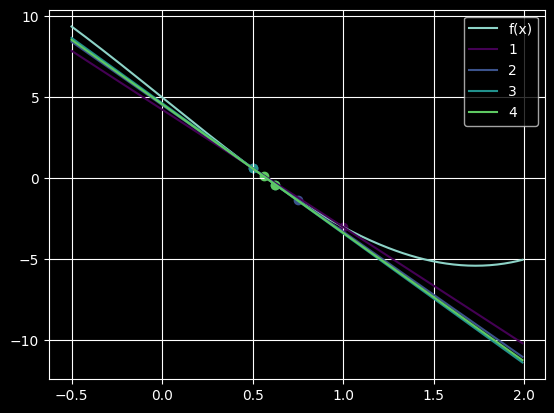

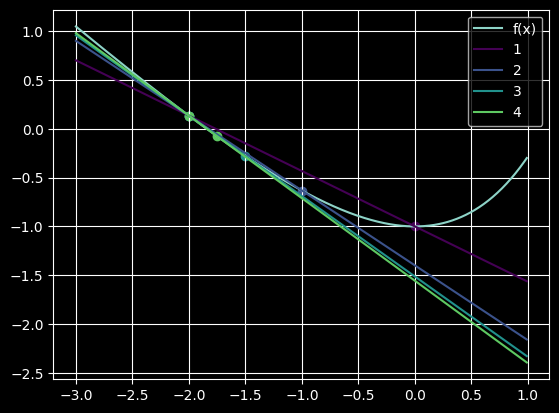

In [3]:
class TestBisection(unittest.TestCase):
    def test_raises_when_no_root(self):
        with self.assertRaisesRegex(Exception, "f doesn't have a root between 1 and 2"):
            bisection(f=lambda x: x, a=1, b=2, tolerance=0.1)

    def test_first_exercise(self):
        trail = bisection(f=lambda x: x**3 - 9 * x + 5, a=0.5, b=1, tolerance=0.01)

        self.assertEqual(trail.result, 0.5781)

        #                      n    a       b       m       f(a)    f(b)     f(m)
        self.assertEqual(trail[0], [0.5000, 1.0000, 0.7500, 0.6250, -3.0000, -1.3281])
        self.assertEqual(trail[1], [0.5000, 0.7500, 0.6250, 0.6250, -1.3281, -0.3808])
        self.assertEqual(trail[2], [0.5000, 0.6250, 0.5625, 0.6250, -0.3808, 0.1154])
        self.assertEqual(trail[3], [0.5625, 0.6250, 0.5937, 0.1154, -0.3808, -0.1340])
        self.assertEqual(trail[4], [0.5625, 0.5937, 0.5781, 0.1154, -0.1340, -0.0096])

        trail.plot()

    def test_second_exercise(self):
        trail = bisection(f=lambda x: math.e**x - x - 2, a=-2, b=0, max_iterations=5)

        self.assertEqual(trail.result, -1.8125)

        #                      n     a        b        x       f(a)     f(b)     f(x)
        self.assertEqual(trail[0], [-2.0000, 0.0000, -1.0000, 0.1353, -1.0000, -0.6321])
        self.assertEqual(trail[1], [-2.0000, -1.0000, -1.5000, 0.1353, -0.6321, -0.2768])
        self.assertEqual(trail[2], [-2.0000, -1.5000, -1.7500, 0.1353, -0.2768, -0.0762])
        self.assertEqual(trail[3], [-2.0000, -1.7500, -1.8750, 0.1353, -0.0762, 0.0283])
        self.assertEqual(trail[4], [-1.8750, -1.7500, -1.8125, 0.0283, -0.0762, -0.0242])

        trail.plot()


unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestBisection))

# Falsa Posição

https://numericalculator.canbula.com/falseposition

In [4]:
def false_posittion(f, a, b, tolerance=None, max_iterations=None, truncate=True, precision=4):
    return find_root(
        f=f,
        a=a,
        b=b,
        update=lambda a, b: (a * f(b) - b * f(a)) / (f(b) - f(a)),
        tolerance=tolerance,
        max_iterations=max_iterations,
        truncate=truncate,
        precision=precision,
    )

...
----------------------------------------------------------------------
Ran 3 tests in 0.064s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

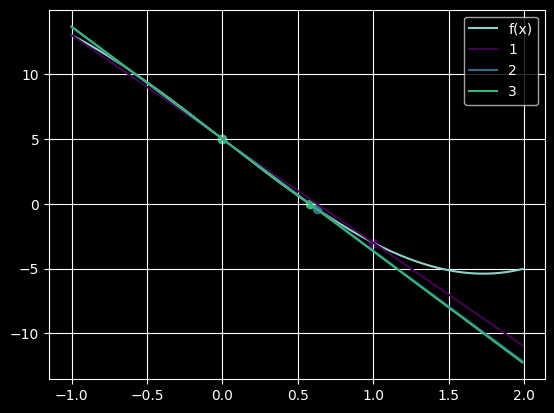

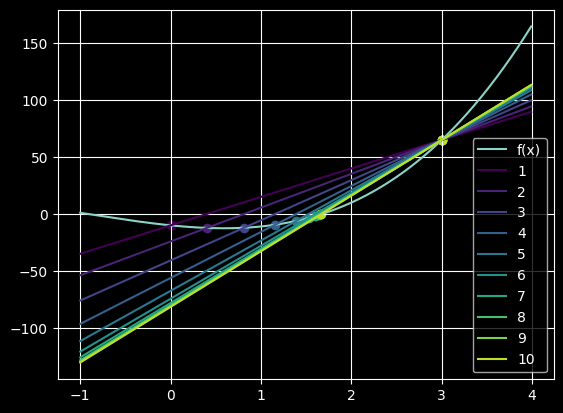

In [5]:
import unittest


class TestFalsePosition(unittest.TestCase):
    def test_raises_when_no_root(self):
        with self.assertRaisesRegex(Exception, "doesn't have a root between 1 and 2"):
            false_posittion(f=lambda x: x, a=1, b=2, tolerance=0.1)

    def test_first_exercise(self):
        trail = false_posittion(
            f=lambda x: x**3 - 9 * x + 5,
            a=0,
            b=1,
            tolerance=0.0005,
        )

        self.assertEqual(trail.result, 0.5769)

        #                      n    a       b       x       f(a)     f(b)     f(x)
        self.assertEqual(trail[0], [0.0000, 1.0000, 0.6250, 5.0000, -3.0000, -0.3808])
        self.assertEqual(trail[1], [0.0000, 0.6250, 0.5807, 5.0000, -0.3808, -0.0304])
        self.assertEqual(trail[2], [0.0000, 0.5807, 0.5771, 5.0000, -0.0304, -0.0017])
        self.assertEqual(trail[3], [0.0000, 0.5771, 0.5769, 5.0000, -0.0017, 0.0000])

        trail.plot()

    def test_second_exercise(self):
        trail = false_posittion(f=lambda x: 2 * x**3 + 5 * x**2 - 8 * x - 10, a=0, b=3, tolerance=0.05, precision=6)

        self.assertEqual(trail.result, 1.672066)

        self.assertEqual(trail[0], [0.000000, 3.000000, 0.400000, -10.000000, 65.000000, -12.272000])
        self.assertEqual(trail[1], [0.400000, 3.000000, 0.812920, -12.272000, 65.000000, -12.124747])
        self.assertEqual(trail[2], [0.812920, 3.000000, 1.156749, -12.124747, 65.000000, -9.468032])
        self.assertEqual(trail[3], [1.156749, 3.000000, 1.391104, -9.468032, 65.000000, -6.068933])
        self.assertEqual(trail[4], [1.391104, 3.000000, 1.528495, -6.068933, 65.000000, -3.404438])
        self.assertEqual(trail[5], [1.528495, 3.000000, 1.601730, -3.404438, 65.000000, -1.767543])
        self.assertEqual(trail[6], [1.601730, 3.000000, 1.638746, -1.767543, 65.000000, -0.880858])
        self.assertEqual(trail[7], [1.638746, 3.000000, 1.656946, -0.880858, 65.000000, -0.430026])
        self.assertEqual(trail[8], [1.656946, 3.000000, 1.665772, -0.430026, 65.000000, -0.207838])
        self.assertEqual(trail[9], [1.665772, 3.000000, 1.670024, -0.207838, 65.000000, -0.099963])
        self.assertEqual(trail[10], [1.670024, 3.000000, 1.672066, -0.099963, 65.000000, -0.047964])

        trail.plot()


unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestFalsePosition))